<a href="https://colab.research.google.com/github/hannahweber244/AIPortfolio/blob/main/VAE_generative_artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import copy

import torch
torch.cuda.empty_cache()


from tqdm.notebook import tqdm

from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_color400_alt(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_color400_alt, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')
        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=6, dilation=3, stride=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,10, kernel_size=4, dilation=1, stride=3)
        self.cnn3_decode = nn.ConvTranspose2d(10,3, kernel_size=40, dilation=1, stride=5)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn3_decode(x))
        else:
            x = F.relu(self.cnn3_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

###############################
###############################
###############################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_color400(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_color400, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')
        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=10, dilation=2, stride=3, output_padding=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,25, kernel_size=7, dilation=2, stride=1)
        self.cnn3_decode = nn.ConvTranspose2d(25,50, kernel_size=10, dilation=6, stride=2, output_padding=5, padding=1)
        #stride = 2, padding=0, dil = 3, kernel =8, output=1
        self.cnn4_decode = nn.ConvTranspose2d(50,10, kernel_size=8, dilation=3, stride=2,output_padding=1, padding=0)
        #stride = 1, padding=0, dil = 9, kernel =10, output=6)
        self.cnn5_decode = nn.ConvTranspose2d(10,3, kernel_size=10, dilation=9, stride=1, padding=0, output_padding=6)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        x = F.relu(self.cnn3_decode(x))
        x = F.relu(self.cnn4_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn5_decode(x))
        else:
            x = F.relu(self.cnn5_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

#############################
#############################
#############################


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class ImageVAE_grey400(nn.Module):

    def __init__(self, rep_dim = 5, sigmoid = True):
        #rep dim = 5
        super(ImageVAE_grey400, self).__init__()
        #speichern der embedding größe um diese nachher bie generation von bildenr nutzen zu können
        self.embedding_dim = rep_dim
        self.batch_size = 1
        self.sigmoid = sigmoid

        if sigmoid:
            print('please use BCEloss as criterion with sigmoid activation function')
        else:
            print('please use BCEWithLogitsLoss as criterion')

        #definieren von polling layern (max pooling layer in verschiedenen größen)
        self.pool_1 = nn.MaxPool2d(3,1)
        self.pool_2 = nn.MaxPool2d(3,2)
        self.pool_3 = nn.MaxPool2d(6,2)

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(1, 10, kernel_size=10, stride=2)
        self.cnn2 = nn.Conv2d(10, 5, kernel_size = 8, stride = 3)
        self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(1*5*5, rep_dim*2)
        self.decode = nn.Linear(rep_dim, 1*5*5)

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(1,5, kernel_size=6, dilation=3, stride=2)
        #die letzten zwei nochmal anpassen!!, dimensionen sind nicht so!
        self.cnn2_decode = nn.ConvTranspose2d(5,10, kernel_size=4, dilation=1, stride=3)
        self.cnn3_decode = nn.ConvTranspose2d(10,1, kernel_size=40, dilation=1, stride=5)

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(rep_dim*2, rep_dim)
        self.log_var = nn.Linear(rep_dim*2, rep_dim)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional and pooling layer
        returns tensor
        '''
        x = self.pool_1(F.relu(self.cnn1(x.float())))
        #x.shape = (N, C, 194, 194)
        x = self.pool_2(F.relu(self.cnn2(x)))
        x = self.pool_3(F.relu(self.cnn3(x)))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,1,5,5)
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = F.relu(self.cnn2_decode(x))
        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn3_decode(x))
        else:
            x = F.relu(self.cnn3_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std


In [ ]:
class VAE_Pipeline400(object):

    def __init__(self, path_images, lr=0.0005, num_epochs = 100, batch_size = 64, color = True):

        #generelle informationen fürs training und zu den daten
        self.path = path_images
        self.epochs = num_epochs
        self.lr = lr
        self.color = color
        self.batch_size = batch_size

        #modell, optimierer und lossfunction platzhalter
        self.model = None
        self.optimizer = None
        self.criterion = None

        #log fü den trainingsloss
        self.loss_log = pd.DataFrame(columns = ['epoche', 'loss'])
        self.reconstruction = dict()


        #listen, die bilder und batches mit bildern enthalten
        self.data = list()
        self.batches = list()

        #funktionen zum einlesen der bilder, erzeugen von batches und
        #trainieren des modells aufrufen, danach kann gernerate funktion der 
        #klasse aufgerufen und neue bilder erzeugt werden
        self.load_images()
        self.create_batches()
        self.train_model()

    def load_images(self):
        images = os.listdir(self.path)
        for i, image in tqdm(enumerate(images)):
            img_path = os.path.join(self.path, image)
            if self.color:
                img = cv2.imread(img_path, 1)
            else:
                img = cv2.imread(img_path, 0)
            #bilder auf einheitliche größe bringen
            img = cv2.resize(img, (400,400))
            self.data.append(img)

    def create_batches(self):
        batch = list()
        random.shuffle(self.data)
        for k, d_  in enumerate(self.data[:200], start = 1):
            if k % self.batch_size == 0:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)#color diemension is last dimension, but needs to be first dimension --> permute
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)
                batch = torch.stack(batch)
                self.batches.append(batch)
                batch = list()
            else:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)

        if len(batch) > 0:
            batch = torch.stack(batch)
            self.batches.append(batch)
            batch = list()

    def final_loss(self, bce_loss, mu, logvar):
        """
        This function will add the reconstruction loss (BCELoss) and the 
        KL-Divergence.
        KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        :param bce_loss: recontruction loss
        :param mu: the mean from the latent vector
        :param logvar: log variance from the latent vector
        """
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def train(self):
        self.model.train()
        running_loss = 0
        key = list(self.reconstruction.keys())[-1]
        for batch_id, batch in enumerate(self.batches):
            self.optimizer.zero_grad()
            out, mu, std = self.model(batch.float())
            self.reconstruction[key].append((batch, out))
            bce_loss = self.criterion(out, batch.float())
            loss = self.final_loss(bce_loss, mu, std)
            running_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            if batch_id % 10 == 0:
                print(f"Fortschritt: {batch_id/len(self.batches)*100}% finished")
        avg_loss = running_loss/len(self.batches)
        return avg_loss

    def train_model(self):
        if self.color:
            self.model = ImageVAE_color400(sigmoid = False).to(device)
        else:
            self.model = ImageVAE_grey400(sigmoid = False).to(device)
        lr = self.lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #wenn logits loss verwendet wird kein sigmoid layer, aber target sollt in [0,1] liegen
        self.criterion = nn.BCEWithLogitsLoss(reduction='sum')
        print(self.model)
        for epoch in range(self.epochs):
            print('epoche:', epoch+1)
            self.reconstruction[epoch] = list()
            train_loss = self.train()
            self.loss_log.loc[len(self.loss_log), :] = [epoch+1, train_loss]

    def generate_images(self, num_images, emb_size = 5, color = False, norm = False):
        for i in range(num_images):
            tensor = torch.zeros(emb_size)
            print(tensor.shape)
            prefix = 'normalized_'
            if not norm:
                prefix = 'random_'
                for k in range(tensor.shape[0]):
                    z = random.randint(-100,10)
                    tensor[k] = z
                tensor = tensor.float().to(device)*torch.randn_like(torch.zeros(emb_size)).to(device)
            else:
                tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
            #tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
            self.model.batch_size = 1
            img = self.model.decode_convolutions(tensor).cpu()
            if self.color:
                img = img.permute(0,2,3,1).detach().numpy()[0]*255
            else:
                img = img.detach().numpy()[0][0]*255
            #print(img.shape)
            cv2_imshow(img)
            #plt.figure()
            #plt.imshow(img/255)
            #img[:, :, 0] = 0
            #img[:, :, 2] = 0
            #cv2_imshow(img)
            #folder = '/content/drive/My Drive/ImageGeneration/generated_images'
            #file_name = prefix+str(i)+'_epoche_20_400400_ersteVersion_withlogitsloss_neueVersion.png'
            #if not os.path.exists(folder):
            #    os.mkdir(folder)
            #cv2.imwrite(os.path.join(folder, file_name), img)
            print('latent vector:', tensor)

In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
van_path = os.path.join(path, artists[0])
print(van_path)
vanGogh = VAE_Pipeline400(van_path, num_epochs = 55)
vanGogh.generate_images(15, color=True)

/content/drive/My Drive/ImageGeneration/artists/Vincent_van_Gogh



please use BCEWithLogitsLoss as criterion
ImageVAE_color400(
  (pool_1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=6, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(3, 10, kernel_size=(10, 10), stride=(2, 2))
  (cnn2): Conv2d(10, 5, kernel_size=(8, 8), stride=(3, 3))
  (cnn3): Conv2d(5, 1, kernel_size=(5, 5), stride=(2, 2))
  (encode): Linear(in_features=25, out_features=10, bias=True)
  (decode): Linear(in_features=5, out_features=25, bias=True)
  (cnn1_decode): ConvTranspose2d(1, 5, kernel_size=(10, 10), stride=(3, 3), dilation=(2, 2), output_padding=(2, 2))
  (cnn2_decode): ConvTranspose2d(5, 25, kernel_size=(7, 7), stride=(1, 1), dilation=(2, 2))
  (cnn3_decode): ConvTranspose2d(25, 50, kernel_size=(10, 10), stride=(2, 2), padding=(1, 1), dilation=(6, 6), output_padding=(5, 5))
  (cnn4_decode): ConvTranspose2d

RuntimeError: ignored

In [ ]:
for epoche, tup_list in vanGogh.reconstruction.items():
    print('epoche:', epoche)
    for original, reconstructed in tup_list:

        orig_ = original[0].cpu().permute(1,2,0).detach().numpy()*255
        recons_ = reconstructed[0].cpu().permute(1,2,0).detach().numpy()*255
        print('original')
        cv2_imshow(orig_)
        print('reconstructed')
        cv2_imshow(recons_)
        break

torch.Size([5])


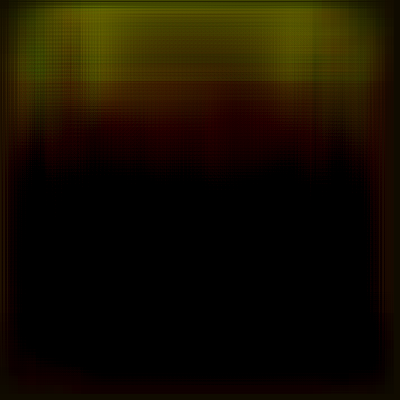

latent vector: tensor([ 0.7931,  0.2937,  0.3813,  0.9573, -1.1447], device='cuda:0')
torch.Size([5])


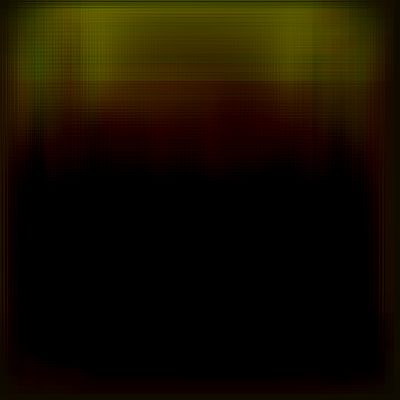

latent vector: tensor([-0.4322, -1.0356, -0.5897, -1.2734, -0.5152], device='cuda:0')
torch.Size([5])


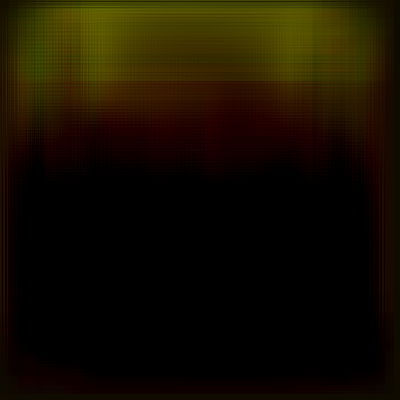

latent vector: tensor([ 1.1863,  0.0421,  0.0059, -1.5978,  0.2231], device='cuda:0')
torch.Size([5])


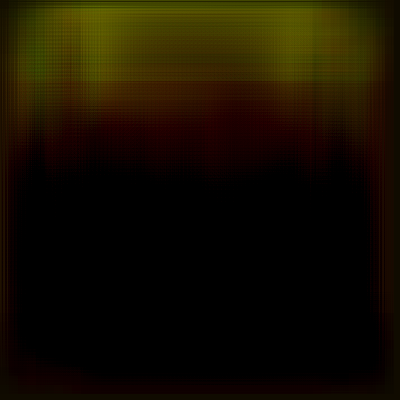

latent vector: tensor([-0.9516, -0.9393,  2.1364, -1.6248,  1.6930], device='cuda:0')
torch.Size([5])


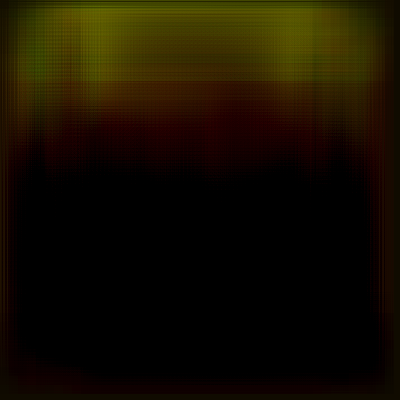

latent vector: tensor([ 1.3882,  1.6012, -0.2253,  0.5103, -0.4019], device='cuda:0')
torch.Size([5])


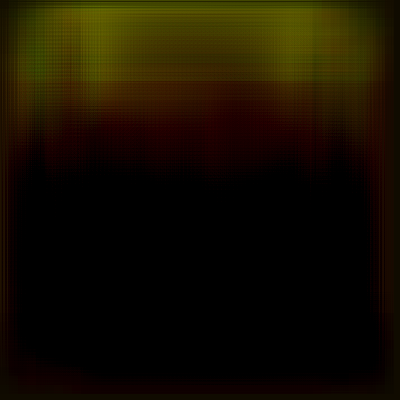

latent vector: tensor([-0.0626,  1.9161, -0.7182,  0.1060, -0.9702], device='cuda:0')
torch.Size([5])


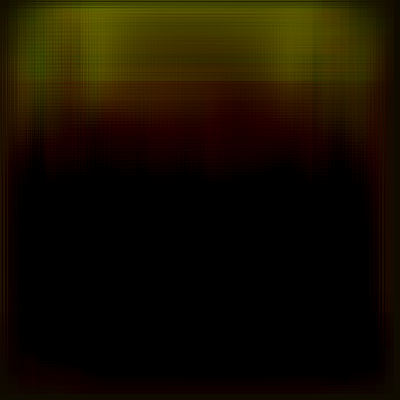

latent vector: tensor([ 0.8855, -0.4503, -1.7349,  1.0166,  0.1653], device='cuda:0')
torch.Size([5])


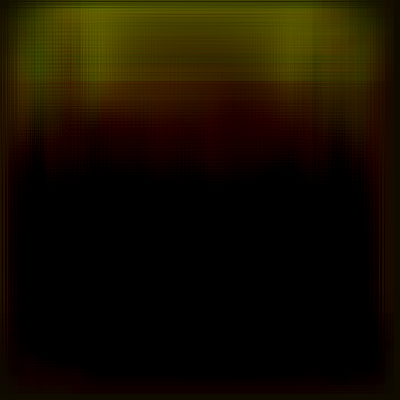

latent vector: tensor([-0.3901, -2.0769, -0.9891,  1.5251, -0.2983], device='cuda:0')
torch.Size([5])


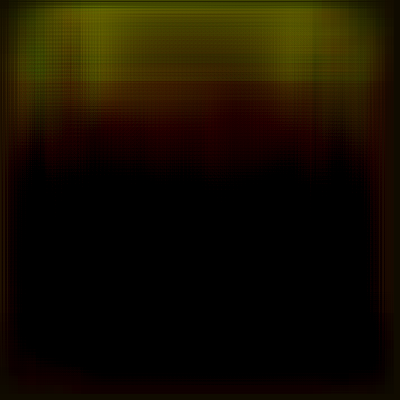

latent vector: tensor([-0.2622,  1.9922,  1.6962,  0.4384, -0.4033], device='cuda:0')
torch.Size([5])


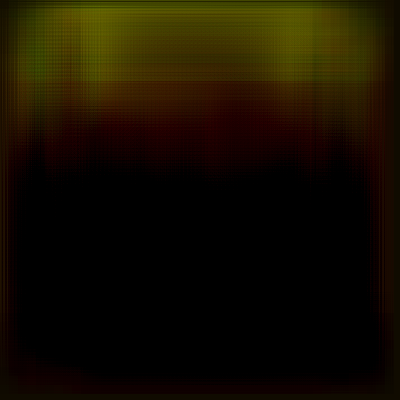

latent vector: tensor([-1.5510,  0.3370,  1.3142,  0.5246, -0.2772], device='cuda:0')
torch.Size([5])


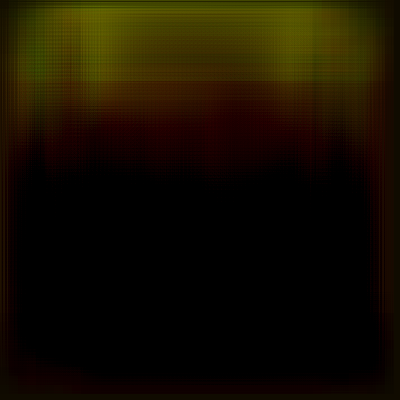

latent vector: tensor([ 1.5252, -2.2631,  1.4376,  0.3427,  1.0065], device='cuda:0')
torch.Size([5])


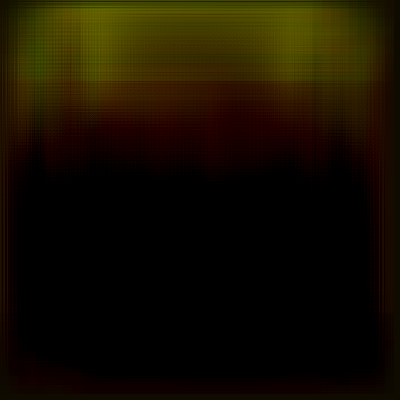

latent vector: tensor([ 0.3749,  0.1125,  1.5637, -1.9566, -0.2186], device='cuda:0')
torch.Size([5])


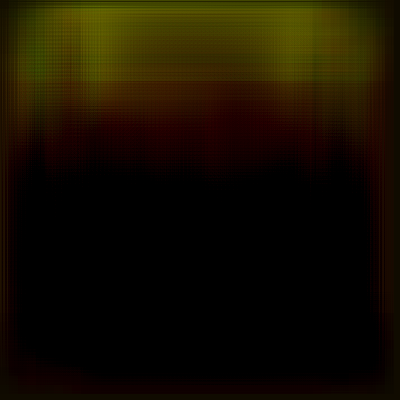

latent vector: tensor([ 1.1468,  0.4748, -0.7677, -0.2920, -1.8053], device='cuda:0')
torch.Size([5])


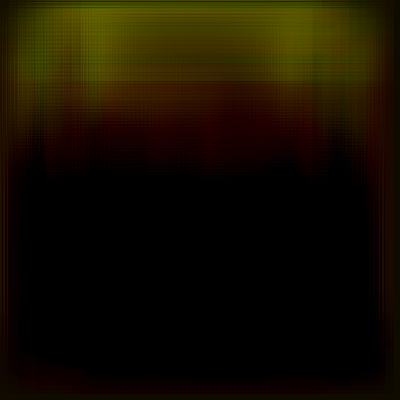

latent vector: tensor([-1.3729, -1.1423,  0.9737, -0.6691,  0.1410], device='cuda:0')
torch.Size([5])


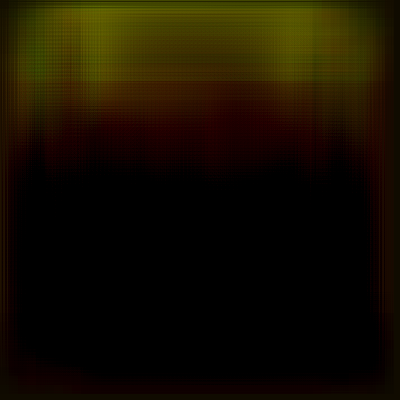

latent vector: tensor([ 0.5704,  0.1235, -1.6513, -0.6352, -0.0485], device='cuda:0')


In [ ]:
vanGogh.generate_images(15, color=True, norm = True)

/content/drive/My Drive/ImageGeneration/artists/Vincent_van_Gogh



please use BCEWithLogitsLoss as criterion
ImageVAE_grey400(
  (pool_1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (pool_2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_3): MaxPool2d(kernel_size=6, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn1): Conv2d(1, 10, kernel_size=(10, 10), stride=(2, 2))
  (cnn2): Conv2d(10, 5, kernel_size=(8, 8), stride=(3, 3))
  (cnn3): Conv2d(5, 1, kernel_size=(5, 5), stride=(2, 2))
  (encode): Linear(in_features=25, out_features=10, bias=True)
  (decode): Linear(in_features=5, out_features=25, bias=True)
  (cnn1_decode): ConvTranspose2d(1, 5, kernel_size=(6, 6), stride=(2, 2), dilation=(3, 3))
  (cnn2_decode): ConvTranspose2d(5, 10, kernel_size=(4, 4), stride=(3, 3))
  (cnn3_decode): ConvTranspose2d(10, 1, kernel_size=(40, 40), stride=(5, 5))
  (mean): Linear(in_features=10, out_features=5, bias=True)
  (log_var): Linear(in_features=10, out_features=5, bias=True)
)
epoche:

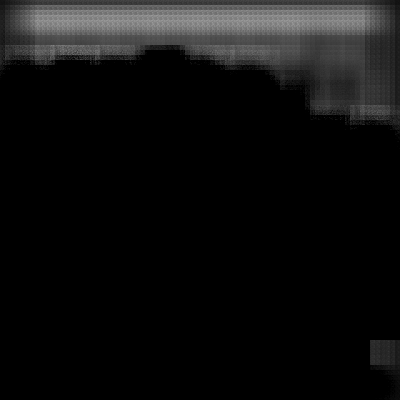

latent vector: tensor([  14.1958,   41.5602,  -18.1004,   -7.7222, -134.8876],
       device='cuda:0')
torch.Size([5])


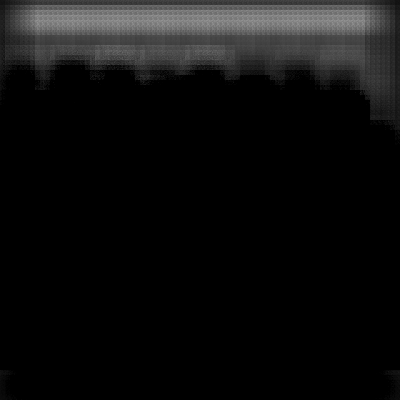

latent vector: tensor([-28.3225,  -3.7030, -82.7330, -15.3095, -21.5471], device='cuda:0')
torch.Size([5])


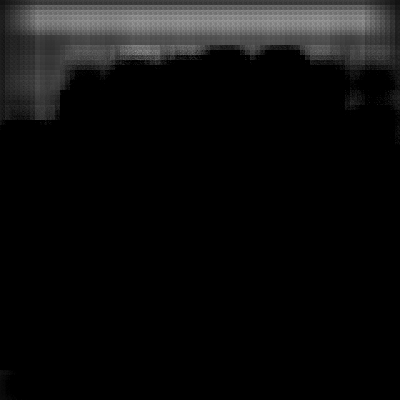

latent vector: tensor([ 36.2413,   5.0159,  -3.8410, -47.9489, 169.5442], device='cuda:0')
torch.Size([5])


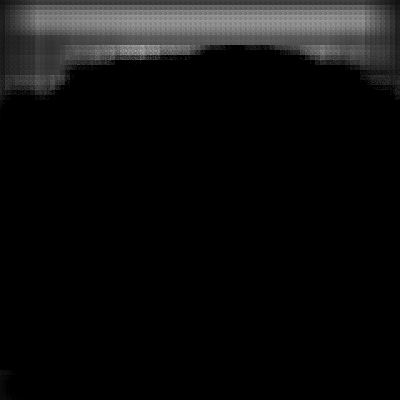

latent vector: tensor([-57.2136,   2.8679,   6.5428,  64.1303, 131.8428], device='cuda:0')
torch.Size([5])


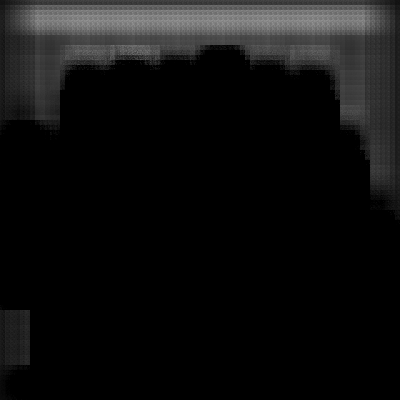

latent vector: tensor([ 43.7786, -51.0813,  43.7717,  98.6647,   8.2031], device='cuda:0')
torch.Size([5])


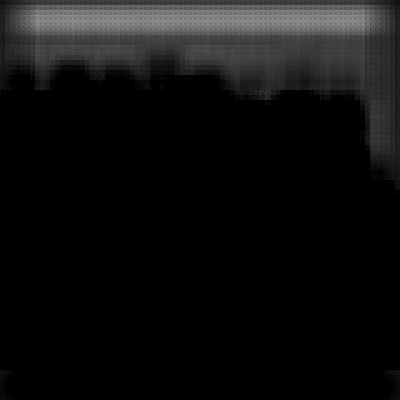

latent vector: tensor([ 14.2145,   4.0711, -32.4591,   9.9275,  -8.9153], device='cuda:0')
torch.Size([5])


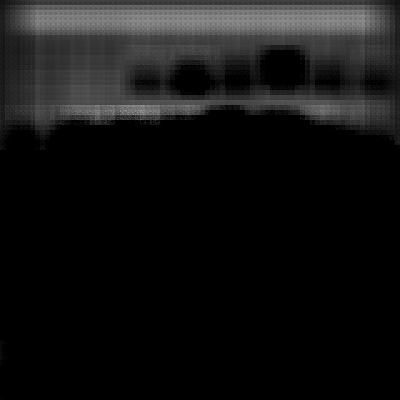

latent vector: tensor([ 67.4084,  23.4824,   5.8828, -81.4774,  63.8742], device='cuda:0')
torch.Size([5])


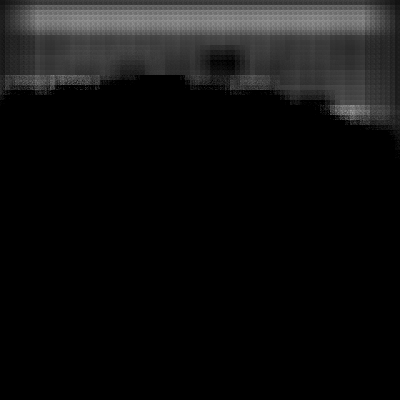

latent vector: tensor([ 78.7059,  75.9851, 117.8412,  32.5406,   1.4130], device='cuda:0')
torch.Size([5])


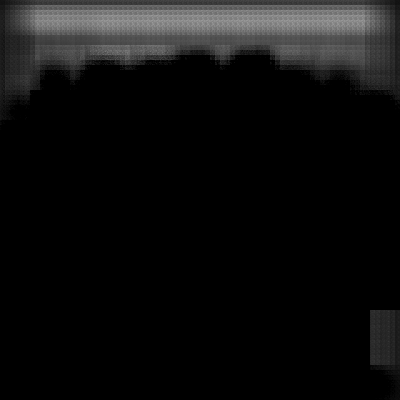

latent vector: tensor([-70.0619,   0.8359,  10.2385,   5.5879,   6.2198], device='cuda:0')
torch.Size([5])


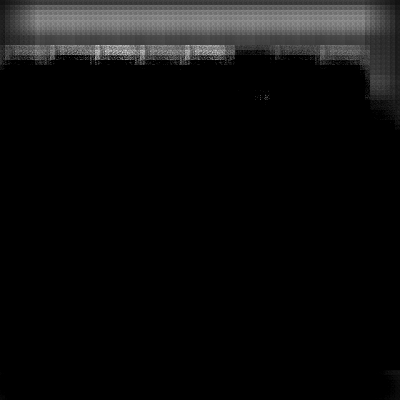

latent vector: tensor([  46.3067,  190.7391, -166.1292,    8.8367,   -2.0070],
       device='cuda:0')
torch.Size([5])


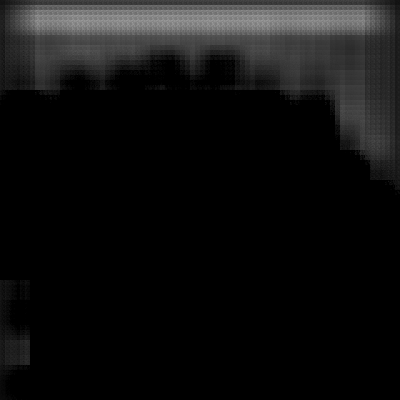

latent vector: tensor([ 58.7050, -10.5995,   0.5954,   7.0674,  -3.2548], device='cuda:0')
torch.Size([5])


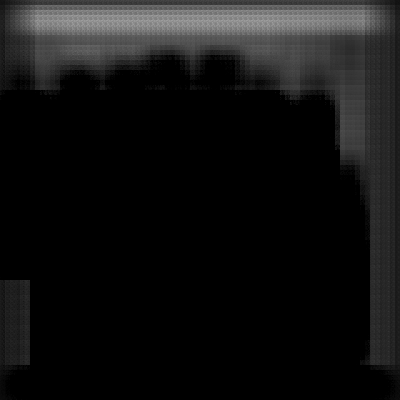

latent vector: tensor([ 18.4790, -31.2259,  23.5357,  47.0526, -40.6492], device='cuda:0')
torch.Size([5])


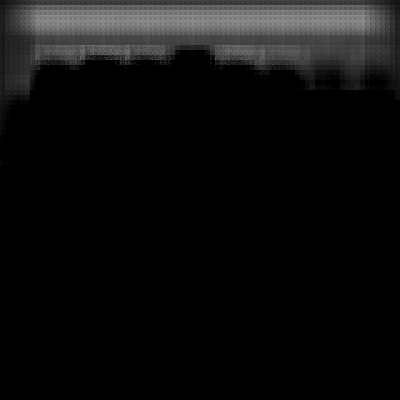

latent vector: tensor([-18.9988,  -7.6771,  76.5276, -54.1599,  -4.1118], device='cuda:0')
torch.Size([5])


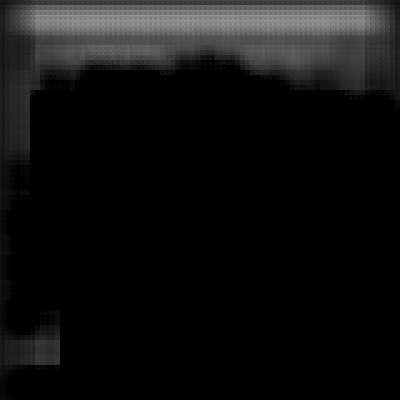

latent vector: tensor([  8.9584, -83.6019,  -4.6446, -26.5365,  -1.6994], device='cuda:0')
torch.Size([5])


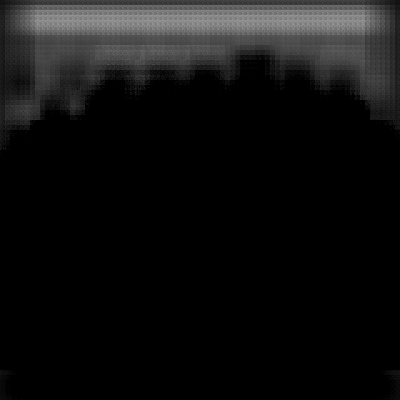

latent vector: tensor([-39.5121,  23.6645, -55.7390, -36.0474,  -1.1589], device='cuda:0')


In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
van_path = os.path.join(path, artists[0])
print(van_path)
vanGogh = VAE_Pipeline400(van_path, num_epochs = 10, color = False)
vanGogh.generate_images(15, color=True)

torch.Size([5])


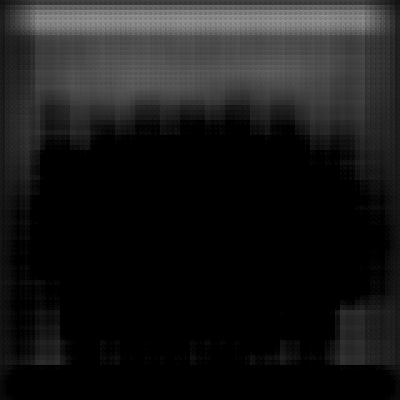

latent vector: tensor([-2.1289, -1.8412,  0.0294, -1.0890,  0.3642], device='cuda:0')
torch.Size([5])


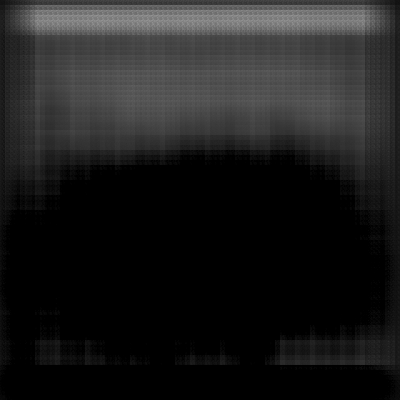

latent vector: tensor([-0.5414,  0.8976,  0.7030, -0.5975,  0.1939], device='cuda:0')
torch.Size([5])


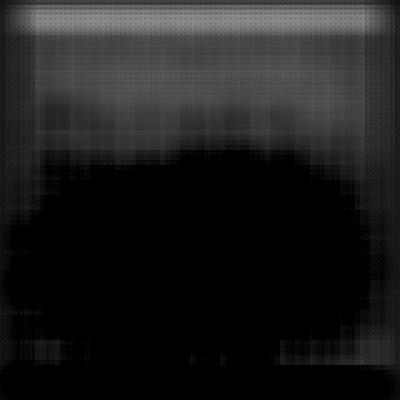

latent vector: tensor([-0.9603,  0.4085,  1.2125,  0.0033, -0.4313], device='cuda:0')
torch.Size([5])


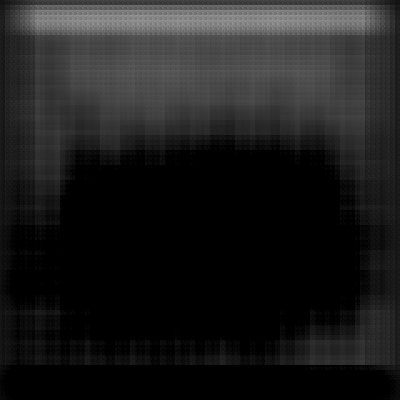

latent vector: tensor([-0.5540, -0.0329,  1.0418,  0.6310,  0.5521], device='cuda:0')
torch.Size([5])


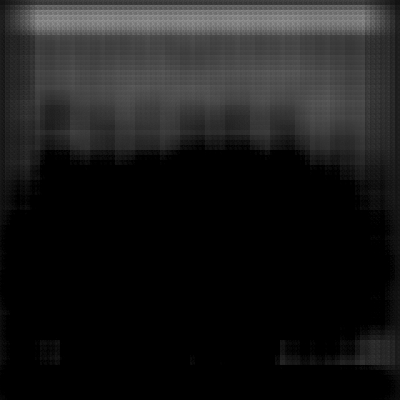

latent vector: tensor([-1.5477,  1.1813,  1.2749, -0.8695, -0.3243], device='cuda:0')
torch.Size([5])


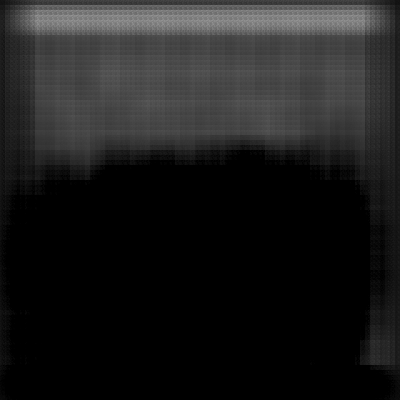

latent vector: tensor([-0.9913,  0.8934, -0.2588,  1.1475, -1.4054], device='cuda:0')
torch.Size([5])


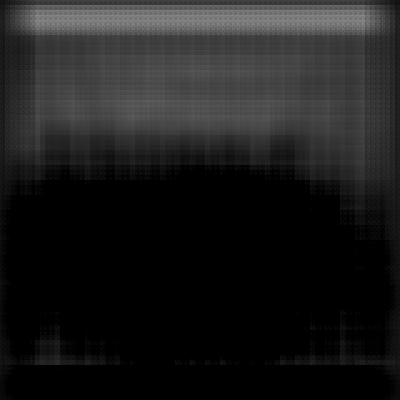

latent vector: tensor([ 0.1134,  0.4535, -1.1932, -0.9115,  0.0244], device='cuda:0')
torch.Size([5])


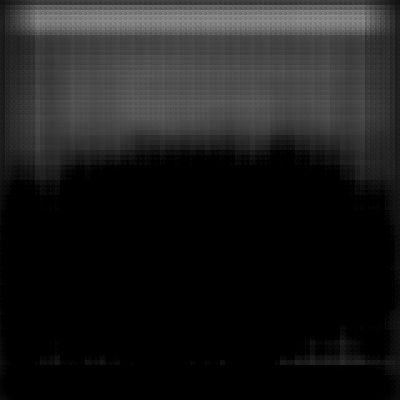

latent vector: tensor([-0.2709,  1.4118, -0.5337, -0.7211,  1.3046], device='cuda:0')
torch.Size([5])


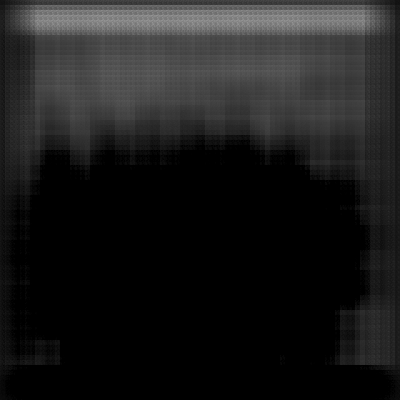

latent vector: tensor([-1.5747, -0.9051, -0.8216, -0.1022, -1.0270], device='cuda:0')
torch.Size([5])


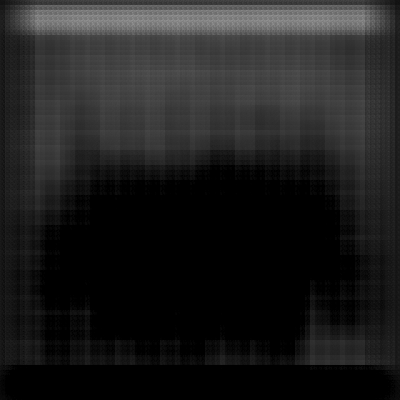

latent vector: tensor([ 0.7465, -0.0813,  0.5986,  0.1220, -0.2839], device='cuda:0')
torch.Size([5])


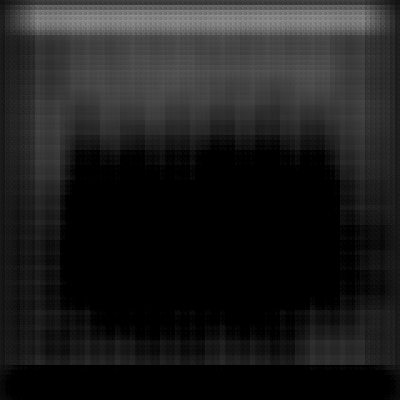

latent vector: tensor([-0.0203, -0.6351,  0.3745,  0.4987,  0.8113], device='cuda:0')
torch.Size([5])


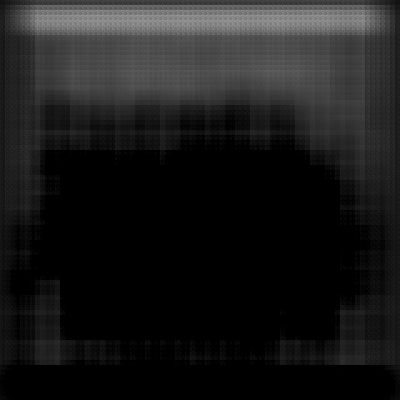

latent vector: tensor([-1.1808, -0.6910,  1.6287, -0.4619,  0.4588], device='cuda:0')
torch.Size([5])


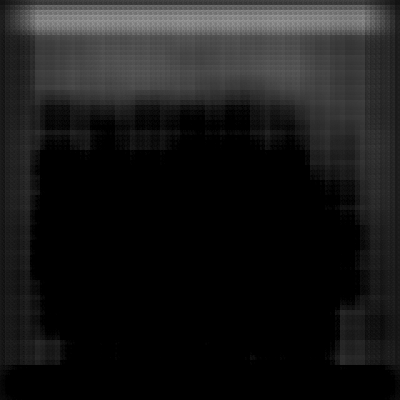

latent vector: tensor([-1.2560, -2.4124,  1.3903, -0.6020, -1.1195], device='cuda:0')
torch.Size([5])


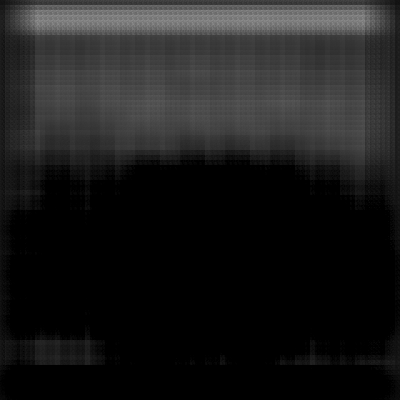

latent vector: tensor([ 0.8838,  1.2008, -0.2189, -1.4439, -0.9662], device='cuda:0')
torch.Size([5])


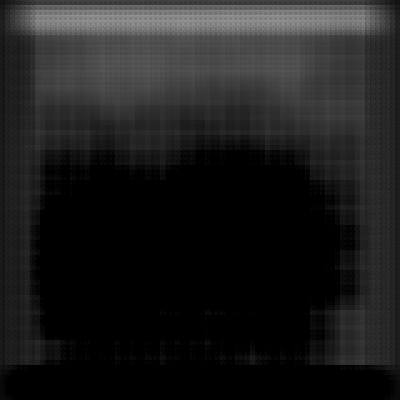

latent vector: tensor([-0.4035, -1.2911,  0.4258,  0.2629, -1.1173], device='cuda:0')


In [ ]:
vanGogh.generate_images(15, color=True, norm = True)

# VAE kleiner als 400 x 400 
Weil 400 x 400 sowohl für Grafikkarrte, als auch für Rekonstruktion absolut überambitioniert ist!

Ansonsten kann auch überlegt werden die Embeddinggröße zu vergrößern, um Ergebnisse zu verbessern.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pandas as pd
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
import cv2
import copy

import torch
torch.cuda.empty_cache()


from tqdm.notebook import tqdm

from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


weitere Verbesserungspotetntiale:
1. Mehr Batchnormalisierung (?)
2. Größere Embeddinggröße
3. Mehr (kleinschrittige) Convolutionlayer

In [2]:
h,w = 64,64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VAEsmall_color(nn.Module):

    def __init__(self, emb_size = 30, sigmoid=False):
        super(VAEsmall_color, self).__init__()
        self.sigmoid = sigmoid

        #batch normalisierungs layer
        self.batch_norm1 = nn.BatchNorm2d(8)
        self.batch_norm2 = nn.BatchNorm2d(24)
        self.batch_norm3 = nn.BatchNorm2d(32)

        #dropout layer
        self.dropout1 = nn.Dropout2d()
        self.dropout2 = nn.Dropout()

        #Encode-Convolutional-Layer
        self.cnn1 = nn.Conv2d(3, 8, kernel_size=4, stride=2)#31x31
        self.cnn2 = nn.Conv2d(8, 15, kernel_size = 3, stride = 1)#29x29
        self.cnn3 = nn.Conv2d(15, 24, kernel_size=3, stride=2)#14x14
        self.cnn4 = nn.Conv2d(24,32, kernel_size=3, stride=1)#12x12
        self.cnn5 = nn.Conv2d(32,42,kernel_size = 6, stride=3)#bider in 3x3 dimension
        #elif emb_size == 2:

        #self.cnn3 = nn.Conv2d(5, 1, kernel_size=5, stride=2)

        #linear layer, nimmt convolution entgegen
        self.encode = nn.Linear(42*3*3, emb_size*2)#'''hier das geiche vll doch nochmal convolution so anassen dass größer?'''
        self.decode = nn.Linear(emb_size, 42*3*3)#von repräsentationsgröße wieder auf die, die in 2d darstellungen verarbeitet werden kann

        #decode convolutional layer
        self.cnn1_decode = nn.ConvTranspose2d(42,32, kernel_size=6, dilation=1, stride=2)#10x10
        self.cnn2_decode = nn.ConvTranspose2d(32,24, kernel_size=6, dilation=1, stride=2)#24x24
        self.cnn3_decode = nn.ConvTranspose2d(24,15, kernel_size=4, dilation=1, stride=2)#50x50
        self.cnn4_decode = nn.ConvTranspose2d(15,8, kernel_size=8, dilation=1, stride=1)#57x57
        self.cnn5_decode = nn.ConvTranspose2d(8,3, kernel_size=8, dilation=1, stride=1)#64x64

        #linear layer um log variance und mean zu erzeugen
        self.mean = nn.Linear(emb_size*2, emb_size)
        self.log_var = nn.Linear(emb_size*2, emb_size)

    def encode_convolutions(self,x):
        '''
        takes input and uses convolutional layer
        returns tensor
        '''
        x = F.relu(self.cnn1(x.float()))
        x = self.batch_norm1(x)
        x = F.relu(self.cnn2(x))
        x = F.relu(self.cnn3(x))
        x = self.batch_norm2(x)
        x = F.relu(self.cnn4(x))
        x = self.batch_norm3(x)
        x = F.relu(self.cnn5(x))
        return x

    def sample(self, x):
        x = F.relu(self.encode(x.flatten(start_dim=1)))#flatten der bild matrix zu einem tensor
        mean_ = self.mean(x)#layer, da die dimension auf die embeddingsize reduziert
        #auch layer, das input auf die embeddingsize reduziert
        log_var = torch.exp(0.5*self.log_var(x))
        assert log_var.shape == mean_.shape#check für mich
        #normalverteiten rauschenvektor erstellen mit dimension von log var / mean
        n_ = torch.randn_like(log_var)

        #sample aus der so berechneten verteilung ziehen
        sample = mean_ + (n_*log_var)
        #sample, mean und std returnen (werden für loss benötigt)
        return sample, mean_, log_var

    def decode_convolutions(self, sample_):
        #sample mit linear decoder in so eine form bringen, dass es 
        #in einem nächsten schritt in benötigte form für conv layer 
        #gebracht werden kann und bild rekonstruiert werden kann
        #sample mit hier uafzunehmen ist wegen verwendbarkeit des decoders
        #im generationsschritt sinnvoll
        x = F.relu(self.decode(sample_))

        #reshapen der dimensionen, für richtiges convtranspose format
        x = x.view(self.batch_size,42,3,3)#1.5.5
        #hier die richtige dimension!!!
        
        #transposed convolutions nutzen, um ursprüngliche 
        #bildgröße wieder herzustellen
        x = F.relu(self.cnn1_decode(x))
        x = self.batch_norm3(x)
        x = F.relu(self.cnn2_decode(x))
        x = self.batch_norm2(x)
        x = F.relu(self.cnn3_decode(x))
        x = F.relu(self.cnn4_decode(x))
        x = self.batch_norm1(x)

        #vorher war hier relu und danach erst sigmoid
        if self.sigmoid:
            x = torch.sigmoid(self.cnn5_decode(x))
        else:
            x = F.relu(self.cnn5_decode(x))
        return x

    def forward(self,x):
        #encoden des inputs mit hilfe 
        self.batch_size = x.shape[0]
        encoded = self.encode_convolutions(x)
        sample_, mean, std = self.sample(encoded)

        #decoden des samples mit linear layer, um auf 5*5 bilddimension im
        #convolutional decoder zugreifen zu können
        #x = F.relu(self.decode(sample_))

        #aufrufen der convolutional transposed layer für den decoder
        #teil des VAE

        #sigmoid wegen bce cuda error: device side assert triggerd nn.Sigmoid(
        reconstructed = self.decode_convolutions(sample_)
        return reconstructed, mean, std

In [3]:
class VAE_Pipeline64(object):

    def __init__(self, path_images, lr=0.0005, num_epochs = 100, batch_size = 64, color = True):

        #generelle informationen fürs training und zu den daten
        self.path = path_images
        self.epochs = num_epochs
        self.lr = lr
        self.color = color
        self.batch_size = batch_size

        #modell, optimierer und lossfunction platzhalter
        self.model = None
        self.optimizer = None
        self.criterion = None

        #log fü den trainingsloss
        self.loss_log = pd.DataFrame(columns = ['epoche', 'loss'])
        self.reconstruction = dict()


        #listen, die bilder und batches mit bildern enthalten
        self.data = list()
        self.batches = list()

        #funktionen zum einlesen der bilder, erzeugen von batches und
        #trainieren des modells aufrufen, danach kann gernerate funktion der 
        #klasse aufgerufen und neue bilder erzeugt werden
        self.load_images()
        self.create_batches()
        self.train_model()

    def load_images(self):
        images = os.listdir(self.path)
        for i, image in tqdm(enumerate(images)):
            img_path = os.path.join(self.path, image)
            if self.color:
                img = cv2.imread(img_path, 1)
            else:
                img = cv2.imread(img_path, 0)
            #bilder auf einheitliche größe bringen
            img = cv2.resize(img, (64,64))
            self.data.append(img)

    def create_batches(self):
        batch = list()
        random.shuffle(self.data)
        for k, d_  in enumerate(self.data[:200], start = 1):
            if k % self.batch_size == 0:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)#color diemension is last dimension, but needs to be first dimension --> permute
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)
                batch = torch.stack(batch)
                self.batches.append(batch)
                batch = list()
            else:
                if self.color:
                    img = torch.from_numpy(d_/255).permute(2,0,1).to(device)
                else:
                    img = torch.from_numpy(cv2.equalizeHist(copy.deepcopy(d_))/255).unsqueeze(0).to(device)
                #img = torch.from_numpy(d_/255).unsqueeze(0).to(device)
                batch.append(img)

        if len(batch) > 0:
            batch = torch.stack(batch)
            self.batches.append(batch)
            batch = list()

    def final_loss(self, bce_loss, mu, logvar):
        """
        This function will add the reconstruction loss (BCELoss) and the 
        KL-Divergence.
        KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        :param bce_loss: recontruction loss
        :param mu: the mean from the latent vector
        :param logvar: log variance from the latent vector
        """
        BCE = bce_loss 
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def train(self):
        self.model.train()
        running_loss = 0
        key = list(self.reconstruction.keys())[-1]
        for batch_id, batch in enumerate(self.batches):
            self.optimizer.zero_grad()
            out, mu, std = self.model(batch.float())
            self.reconstruction[key].append((batch, out))
            bce_loss = self.criterion(out, batch.float())
            loss = self.final_loss(bce_loss, mu, std)
            running_loss += loss.item()
            loss.backward()
            self.optimizer.step()
            if batch_id % 10 == 0:
                print(f"Fortschritt: {batch_id/len(self.batches)*100}% finished")
        avg_loss = running_loss/len(self.batches)
        return avg_loss

    def train_model(self):
        if self.color:
            self.model = VAEsmall_color(sigmoid = False).to(device)
        else:
            print('version without color not implemented yet!')
            #self.model = ImageVAE_grey400(sigmoid = False).to(device)
        lr = self.lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        #wenn logits loss verwendet wird kein sigmoid layer, aber target sollt in [0,1] liegen
        self.criterion = nn.BCEWithLogitsLoss(reduction='sum')
        print(self.model)
        for epoch in range(self.epochs):
            print('epoche:', epoch+1)
            self.reconstruction[epoch] = list()
            train_loss = self.train()
            self.loss_log.loc[len(self.loss_log), :] = [epoch+1, train_loss]

    def generate_images(self, num_images, emb_size = 30, color = True, norm = False):
        self.model.eval()
        with torch.no_grad():
            for i in range(num_images):
                tensor = torch.zeros(emb_size)
                print(tensor.shape)
                prefix = 'normalized_'
                if not norm:
                    prefix = 'random_'
                    for k in range(tensor.shape[0]):
                        z = random.randint(-100,10)
                        tensor[k] = z
                    tensor = tensor.float().to(device)*torch.randn_like(torch.zeros(emb_size)).to(device)
                else:
                    tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
                #tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
                self.model.batch_size = 1
                img = self.model.decode_convolutions(tensor).cpu()
                if self.color:
                    img = img.permute(0,2,3,1).detach().numpy()[0]*255
                else:
                    img = img.detach().numpy()[0][0]*255
                #print(img.shape)
                img = cv2.resize(img, (300,300))
                cv2_imshow(img)
                #plt.figure()
                #plt.imshow(img/255)
                #img[:, :, 0] = 0
                #img[:, :, 2] = 0
                #cv2_imshow(img)
                #folder = '/content/drive/My Drive/ImageGeneration/generated_images'
                #file_name = prefix+str(i)+'_epoche_20_400400_ersteVersion_withlogitsloss_neueVersion.png'
                #if not os.path.exists(folder):
                #    os.mkdir(folder)
                #cv2.imwrite(os.path.join(folder, file_name), img)
                print('latent vector:', tensor)

/content/drive/My Drive/ImageGeneration/artists/Vincent_van_Gogh



VAEsmall_color(
  (batch_norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (cnn1): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2))
  (cnn2): Conv2d(8, 15, kernel_size=(3, 3), stride=(1, 1))
  (cnn3): Conv2d(15, 24, kernel_size=(3, 3), stride=(2, 2))
  (cnn4): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1))
  (cnn5): Conv2d(32, 42, kernel_size=(6, 6), stride=(3, 3))
  (encode): Linear(in_features=378, out_features=60, bias=True)
  (decode): Linear(in_features=30, out_features=378, bias=True)
  (cnn1_decode): ConvTranspose2d(42, 32, kernel_size=(6, 6), stride=(2, 2))
  (cnn2_decode): ConvTranspose2d(32, 24, kernel_size=(6, 6), stride=(2, 2))
  (cnn3_decode): ConvTrans

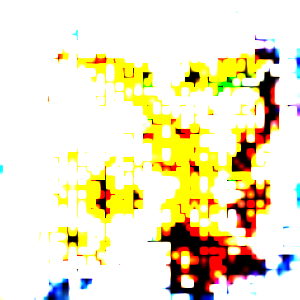

latent vector: tensor([  -4.7378,  -12.2352,   -8.4532,    2.3568,   -1.1501,  -43.7618,
        -101.6950,    4.9789,  -24.2517,    4.6850,  -97.2717,    4.3015,
          30.8380,    1.8075,   94.4254,    0.2835,   26.5617,    0.0000,
           1.2667, -117.9685,   -5.0650,    3.3560, -108.9671,    8.2505,
          22.4920,   -7.5070,   85.0549,   -6.6282,  -34.6973,  141.1757],
       device='cuda:0')
torch.Size([30])


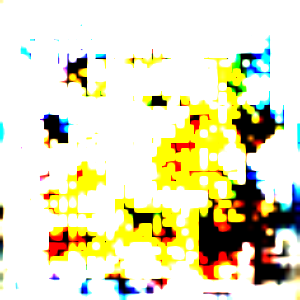

latent vector: tensor([ 6.3543e-01,  2.3069e+01, -2.1726e+01, -1.8421e+01,  1.3739e+02,
        -7.3178e+01,  6.1509e+01,  1.9250e+00,  6.9214e+01,  4.6738e+01,
        -2.0364e+00, -3.3878e+01, -8.2195e+00,  5.6772e+00,  1.3881e+01,
        -7.8080e+01,  3.2612e+00, -1.1969e+01, -7.4322e+00,  3.8007e+01,
        -4.7862e+01,  3.6063e+00, -8.7077e+01, -8.5911e+00, -1.1365e+01,
         7.1873e+00,  1.7447e+00, -2.9507e+01,  4.2573e+01, -1.8633e-03],
       device='cuda:0')
torch.Size([30])


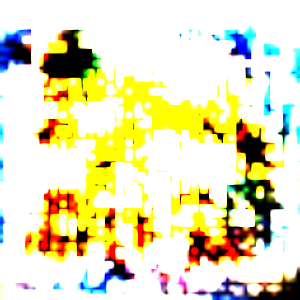

latent vector: tensor([-14.7532,  -4.6487,  14.2371,  -5.9052,   1.5615,   4.6641,   2.9675,
         37.4484,  31.9509,  41.9059, -26.1305, -78.3737, -32.2939,  -9.4849,
        -68.3908, -11.5758,   0.9316, -39.6407,   6.5547,  -2.0214,  -1.1948,
          8.7679, -35.7420,   4.8985,  -0.3956, -22.8194,  -4.4468,   5.5610,
         32.3094,   0.2057], device='cuda:0')
torch.Size([30])


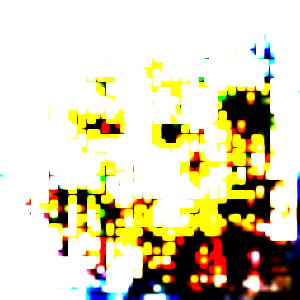

latent vector: tensor([  10.6355,   95.2423, -164.9296,   10.5464,   13.1305,    0.6315,
           0.3011,  139.1567,  -20.9129,    0.2315,   60.1503,  -10.7568,
         116.3942,  -51.3854,  -10.8888,  -21.6212,   53.5753,   85.8735,
           7.1396,   -4.1109,  -26.2520,   -4.2589,    5.4816,   16.5664,
           0.5340,   17.2947,   10.8721,   12.0724,   12.8728,   -5.4350],
       device='cuda:0')
torch.Size([30])


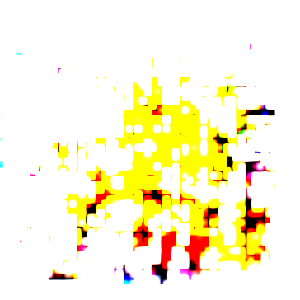

latent vector: tensor([ 1.9265e+01,  2.9952e+00, -8.8334e-02,  1.9700e+01,  7.6440e+00,
        -1.3458e+01, -5.6074e+00, -8.3793e+01,  4.1728e+01,  0.0000e+00,
        -3.3161e+01, -6.6135e+01,  4.9699e+01,  7.0278e+01,  1.3492e+02,
         1.0064e+02, -8.5006e+01, -2.6489e+01, -5.7728e+01,  9.5772e+01,
        -7.6578e+00,  1.3513e+01,  4.5558e+00,  2.9524e+01,  3.9871e+01,
        -9.5882e+01, -1.0559e+02,  5.6772e+01,  1.0415e+00,  2.4981e+01],
       device='cuda:0')
torch.Size([30])


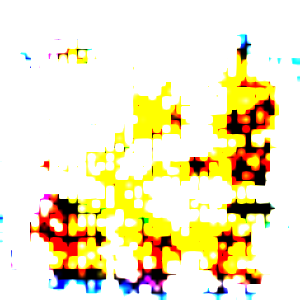

latent vector: tensor([   0.3428,    8.3169,   54.1478,    6.2282,   -4.1079,    7.6676,
          17.3614,  -14.8438,   74.9559,   -0.5377,   -6.8815,  -14.8620,
          10.2038, -134.1965,   -0.7169,  -13.4057,    2.5041,  -63.6939,
          69.4249,   21.5952,   16.2692,  -39.3796,    1.3069,    1.3557,
         129.3956,   -7.5576,   -8.4555,  -26.9247,  113.9387,  -58.6264],
       device='cuda:0')
torch.Size([30])


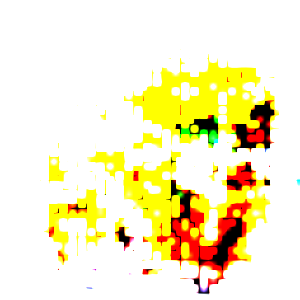

latent vector: tensor([   9.7654,  -16.2172,   18.5397,   -4.2898,  -88.8906,  -11.1969,
         -64.6472,  151.9872,  -64.5414,   -3.6527,    0.7974,  149.9173,
         -26.5672,   11.4436,   21.2533,  -64.5435,   45.2598, -101.3307,
          65.6650,   39.0603,   86.9291,   -1.6869,  -17.0724,   22.3443,
         -33.6331,   32.4035, -152.9189,   -0.7750,  -17.0841,   49.3007],
       device='cuda:0')
torch.Size([30])


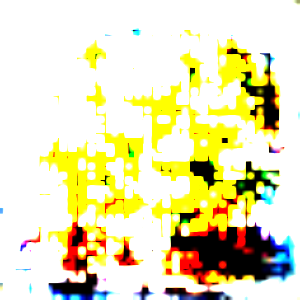

latent vector: tensor([ 71.2422,  19.9085,  70.6351,   0.0000,  46.2989,  12.0339, -66.8504,
        -15.1365, -26.4637,  60.1314,  -5.1977,   7.8821,  50.4964,   8.7817,
        108.8964,   5.6133,  68.6707,   0.0000, -60.7960, -85.9005, -11.6824,
        -23.2891, -22.6979,  28.5173,   7.7970,  21.4168,  38.6816,  55.5209,
        -50.0529,   4.9711], device='cuda:0')
torch.Size([30])


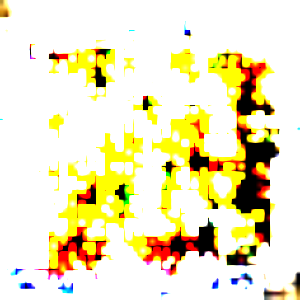

latent vector: tensor([  79.4019,   27.8954,   21.0216,   69.5327,   36.8866,  -17.4721,
         -94.4146,  -14.3598,   -2.0048,  110.5954,  -81.0167, -143.5569,
         167.7093,    8.2322,   12.5685, -111.7028,   91.1095,   20.8287,
         -26.9992,   12.0699,    3.4371,  -12.3215,  -84.6575,  -14.2192,
          68.5146,   -2.9449,  -23.0017,   -7.5987,   34.1057,    0.7341],
       device='cuda:0')
torch.Size([30])


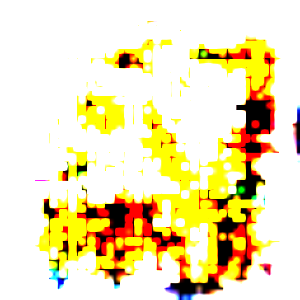

latent vector: tensor([-4.3224e+01,  1.7733e+02, -1.1097e+02,  1.6933e+00,  6.0760e-01,
        -4.3483e+01,  3.1650e+01, -2.5099e+01, -5.6537e+00,  0.0000e+00,
        -1.2193e+02,  4.7563e+01,  4.9784e+00, -3.9066e+01, -6.4036e+00,
        -2.0892e+01,  1.1704e-03,  3.0118e+01,  1.9892e+01, -1.7974e+01,
         0.0000e+00, -1.3452e+01,  2.3177e+00, -7.2990e-02, -4.4660e+01,
         3.5167e+01, -5.1251e+00, -7.9682e-01,  3.6772e+00,  4.7149e+00],
       device='cuda:0')
torch.Size([30])


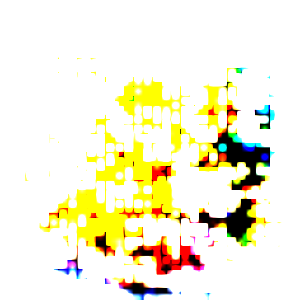

latent vector: tensor([ -22.6672,  -53.6398,   -1.6260,   70.9159,   -1.6262,    1.9735,
        -124.9016,   32.7367,   49.9748,  133.7211,   -5.1041,   21.4047,
           3.3946,    3.0362,    9.6865,   10.9857, -117.5276,  -80.0315,
           9.4709,   28.7158,   69.8378,   -5.9974,    1.9160,    6.7247,
         -23.7849,   -8.3630,   35.1431,  -42.9982,   -3.6407,   27.5802],
       device='cuda:0')
torch.Size([30])


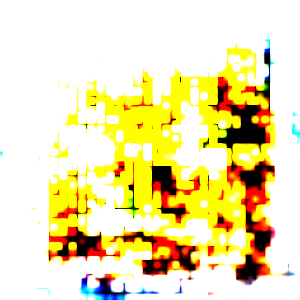

latent vector: tensor([-14.0533,   2.7914, -10.7161,   8.1934, -82.1782,   0.7431,  -3.5439,
          3.1803, -20.3076,   6.6513,  35.2432,  -0.6591,   5.7116,  42.1481,
        -50.7387,   8.7293,  -8.2473,  78.6254, -90.7760,  10.8197, -29.5775,
        -11.3405,  36.1337,  -1.4013, -27.1027,  -1.1295,  22.4396,  -1.3800,
         43.3284,  34.4013], device='cuda:0')
torch.Size([30])


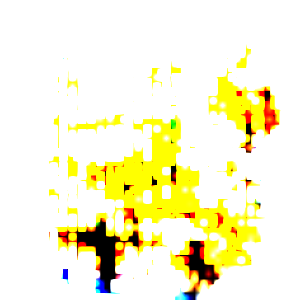

latent vector: tensor([   4.7679,   51.5029,   21.9374,   -0.7859,  -99.0383,    5.4337,
          75.2693,   99.6811,   94.7001,   -0.3395,  -46.4126,   67.7137,
          28.2835,  119.2088,    3.4986,  -66.4541,   -2.8614,  196.4749,
          -6.2105,   34.7484,    0.8811,   30.6780,    3.6295,   -1.2310,
        -129.2777,    1.3378,   23.5133,    1.0085,  -15.2537,   65.1776],
       device='cuda:0')
torch.Size([30])


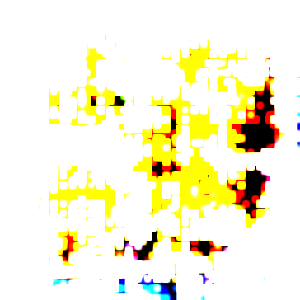

latent vector: tensor([ -19.3400,   93.0476,   -1.3100,  -31.7567,   10.5580,   15.0543,
          30.1446,   88.7186,   14.7037, -212.2369,  -68.1220,    1.3977,
          -4.4330,   -2.6148,   -0.0000,   41.4874,   71.0335,  104.9204,
          47.6857,  -37.9564,   -5.3183,  -36.8252,  -20.9705,  -58.4082,
          -6.1697,   -9.1766,   73.5688,  -18.4207,   12.8959,  288.3964],
       device='cuda:0')
torch.Size([30])


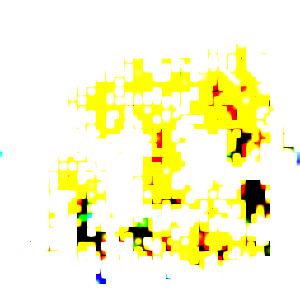

latent vector: tensor([   0.9995,   49.0719,  -15.5097,   31.7016, -218.5975,  -42.9047,
          28.4011,  -75.7967,   83.6426,  -13.2758, -101.7056,  -39.7494,
           3.3344,   93.6030,  -86.5850,   20.3337,  -43.8198,  -24.4588,
          18.8057,   19.1972,   10.8972,  -87.6998,  -25.1234,   13.9766,
         130.2936,  -15.8509,  -33.9071,   -4.1360,   20.1057,   65.1210],
       device='cuda:0')


In [4]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
van_path = os.path.join(path, artists[0])
print(van_path)
vanGogh = VAE_Pipeline64(van_path, num_epochs = 1600)
vanGogh.generate_images(15, color=True)

torch.Size([30])


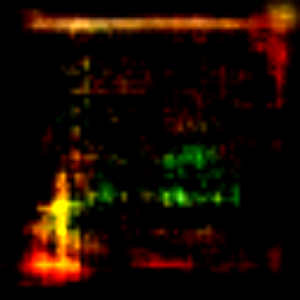

latent vector: tensor([ 0.3197, -0.8933, -0.5779,  0.4834, -0.5674, -1.8087,  0.9617,  1.6248,
        -1.3320, -1.0755,  0.2797,  0.8898, -1.5528,  1.1978,  0.2509, -1.4542,
        -1.0870,  0.3802, -0.6874, -0.3468, -0.2403, -0.4263,  0.2801,  0.7269,
        -0.5379,  1.3175,  1.1127,  1.1263,  3.1674,  1.3839], device='cuda:0')
torch.Size([30])


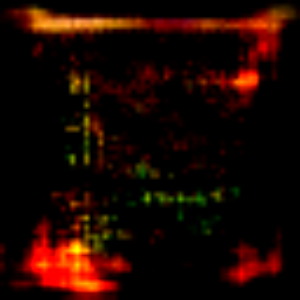

latent vector: tensor([-0.7038,  1.0643, -0.6841, -1.5671, -1.6351,  0.5441, -1.2481, -1.1403,
        -0.7444, -0.4260, -1.3892, -0.9076,  0.2580,  2.6987,  1.3188, -1.1080,
        -0.8004, -0.1008,  0.3398,  1.0189,  0.7687, -1.4622,  0.0255,  1.3601,
        -0.6858, -1.9948, -0.0954,  1.4110, -1.0303,  0.5736], device='cuda:0')
torch.Size([30])


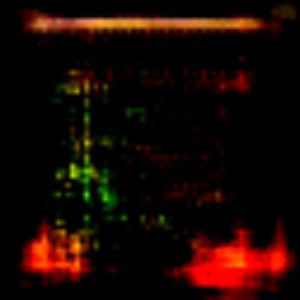

latent vector: tensor([ 0.3905, -0.3865, -0.6890,  0.3616, -0.7433,  1.0010,  0.3830, -1.6746,
         1.6839,  1.3018,  0.4110, -0.4723, -0.5165,  0.1505, -1.0799, -0.6570,
         1.2298, -1.2494, -0.3646, -0.0580,  0.5942,  0.5139,  0.6169,  0.1950,
         0.8191, -0.3999, -2.3166, -0.6129, -0.2683,  0.6552], device='cuda:0')
torch.Size([30])


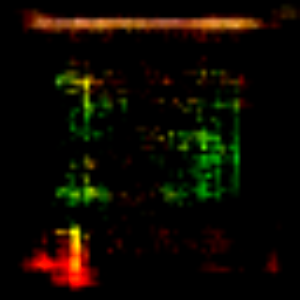

latent vector: tensor([ 2.2430,  0.8149,  0.4650,  0.4974, -1.3599,  0.3595,  0.6495,  0.8631,
         0.1907, -0.5427, -0.7986,  0.2898,  0.0935, -0.2082, -1.2590, -0.8143,
        -0.9374, -1.0806,  2.1750, -1.2874, -1.6453,  2.2381,  1.0248,  1.4420,
         0.3824,  1.7302,  1.0343,  1.3992,  1.1303,  0.9108], device='cuda:0')
torch.Size([30])


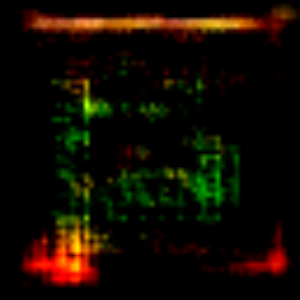

latent vector: tensor([ 0.7726,  0.0658,  0.0215,  0.7379,  0.0543, -0.8783,  0.3209,  0.0921,
        -0.4457,  0.9390,  0.2266, -0.3119,  0.9893,  0.9723,  0.7404, -0.5406,
         0.6089,  0.5347,  2.0755, -0.6425, -0.5220,  0.2239,  0.7135, -0.3731,
         0.7346, -0.7014,  0.1406,  0.5007, -2.3317,  1.5582], device='cuda:0')
torch.Size([30])


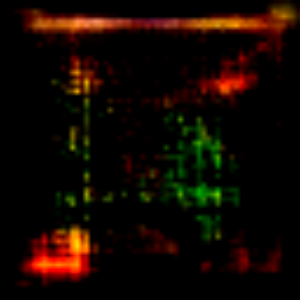

latent vector: tensor([ 0.4850, -0.1716, -1.0981, -0.6479, -1.8717, -0.4281, -0.3986, -1.0816,
        -0.8519, -0.3007,  0.1093,  0.4573, -0.5117, -0.4637,  0.9127,  1.1739,
         0.4064, -0.1893, -0.0578, -0.6122, -2.0424,  1.1659, -0.7791, -0.1512,
         0.0104,  1.4646,  0.4392,  1.4791,  1.0906,  0.7129], device='cuda:0')
torch.Size([30])


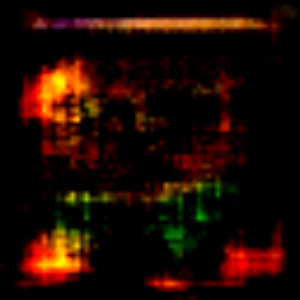

latent vector: tensor([ 1.1611,  0.9492,  0.4161,  1.9102, -0.1569, -0.3004,  1.3065, -1.3303,
        -0.5149,  0.5314,  0.4732, -1.2474, -2.0115,  0.8476,  0.1329,  1.1355,
         0.8408,  2.0144, -1.7800,  1.1057,  1.1596,  0.5199, -1.0736, -0.1909,
        -0.9238, -0.1828, -0.1023,  0.1623,  0.0727,  0.4532], device='cuda:0')
torch.Size([30])


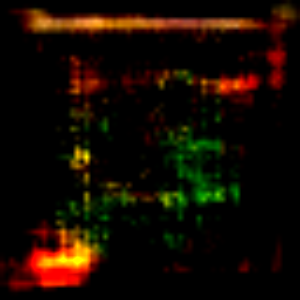

latent vector: tensor([-0.2501,  0.1623,  0.3174, -2.0798, -0.2784, -1.7838, -1.2754, -0.6984,
         0.7002,  0.0645, -1.0019,  0.7290, -0.4053,  1.3714, -0.9202,  0.0032,
        -0.0306,  1.2731, -1.8690,  0.3253, -0.4966, -0.5848, -0.5748,  0.8261,
        -0.0669, -0.9518,  0.9505,  0.0300,  0.1836,  1.9070], device='cuda:0')
torch.Size([30])


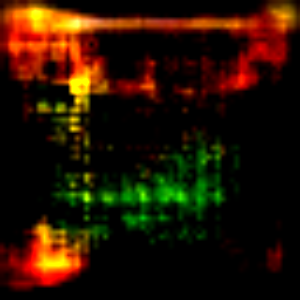

latent vector: tensor([-0.7776,  0.8817,  0.0433, -0.0982, -0.7210, -0.5991, -0.6190,  1.3002,
        -0.6140, -1.7151,  1.1691,  1.4600,  0.3751, -1.0241, -0.3091, -0.9436,
         0.2633, -0.0394, -1.5715,  0.6652, -0.4302, -0.3862, -1.5086,  0.4615,
        -0.7858,  0.6268, -0.8759,  0.1598, -0.4636,  0.7495], device='cuda:0')
torch.Size([30])


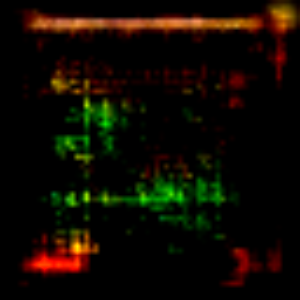

latent vector: tensor([ 1.0489,  0.2871,  0.6409,  0.5247,  1.1686, -2.1668,  0.9776,  0.5442,
        -0.7152, -0.5931,  2.4304, -0.5934,  0.3726,  0.1121, -1.5394,  0.5794,
        -0.7545,  0.4056, -0.5293,  0.1265, -0.8299,  0.8269, -1.0810, -0.8936,
        -0.6707,  0.9694, -0.1497,  0.3393, -0.5911,  1.0635], device='cuda:0')
torch.Size([30])


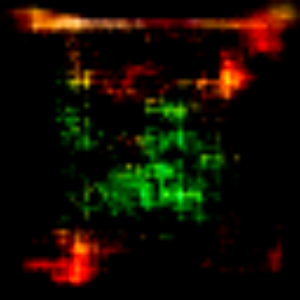

latent vector: tensor([ 0.0046, -0.6564,  1.9911, -0.8302,  0.2417, -0.2121, -1.3831, -0.3663,
        -2.2149, -0.7762, -1.5731,  0.2548, -0.3293, -0.4821,  0.3787, -1.8666,
        -0.0422, -0.9098,  1.1889,  3.1022, -0.0321,  0.0640,  2.5316, -1.7165,
        -0.8976, -0.1554, -0.2521,  1.6129, -0.7833, -0.7062], device='cuda:0')
torch.Size([30])


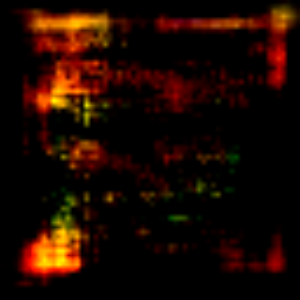

latent vector: tensor([ 0.7996, -1.0549,  0.6957,  0.8516, -1.2242, -0.0600,  1.4359,  1.7008,
         0.9535, -2.3238,  1.6224, -1.8683,  0.0967,  0.6399, -0.5723,  0.2930,
         0.8951,  0.5740, -0.2443,  0.5834, -0.0358,  0.8211, -1.9061,  1.1388,
         0.7714,  1.5798, -0.1736,  0.8843,  0.8697,  1.6945], device='cuda:0')
torch.Size([30])


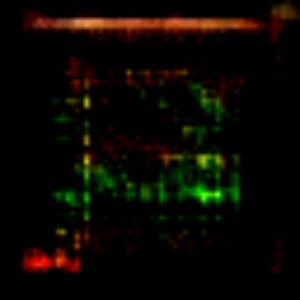

latent vector: tensor([-0.1548,  0.1219,  0.9477,  1.7836,  1.0736, -0.3503, -1.5806,  0.0907,
         0.4398, -0.2673,  0.1283, -1.6324, -0.3124,  0.3823,  0.2922, -0.9181,
         0.4550,  0.7943,  0.3403, -0.0784, -0.2993, -1.3333, -1.9920,  1.0853,
         0.4167, -0.9174,  0.2331, -0.2150,  0.3982, -1.2814], device='cuda:0')
torch.Size([30])


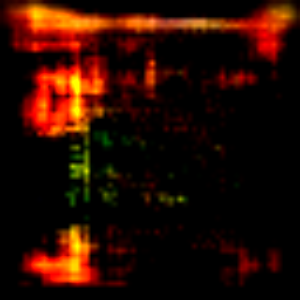

latent vector: tensor([ 0.0449,  0.6285, -2.5333, -1.7077, -0.1117,  0.7514, -0.5579,  0.0648,
        -1.8542, -1.1813,  0.3789,  0.9964, -0.5365, -0.6323,  0.8467,  0.1998,
        -1.4188,  0.7638,  1.3172,  0.4318,  0.1524, -1.5456, -0.1028, -0.8083,
         2.2439, -2.2090, -1.0586,  1.2416,  1.3298, -0.4059], device='cuda:0')
torch.Size([30])


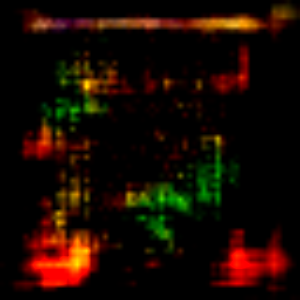

latent vector: tensor([ 0.6002,  1.3501,  0.7212,  1.5646,  1.0822, -0.3203,  0.1305,  0.0458,
        -0.9289,  0.4768, -0.8508,  1.5923, -1.2886,  0.2867, -2.4597,  1.6397,
         1.0892,  0.0518, -0.4555, -1.4285,  0.8708,  0.7623,  1.0933, -0.6060,
         1.0267,  1.0755, -0.0430,  0.7520, -0.2255,  1.2691], device='cuda:0')


In [6]:
vanGogh.generate_images(15, color=True, norm = True)

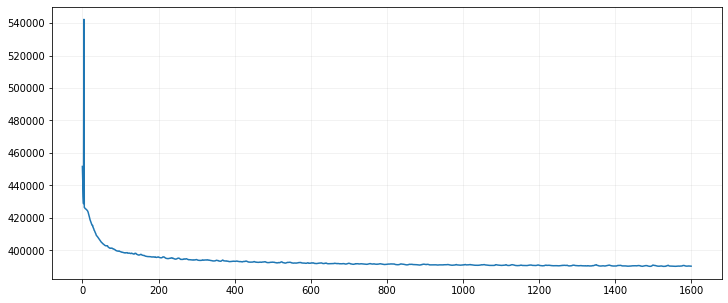

In [7]:
plt.figure(figsize=(12,5))
vanGogh.loss_log.loss.plot()
plt.grid(alpha=0.2)

epoche: 0
original


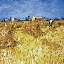

reconstructed


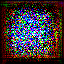

epoche: 10
original


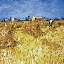

reconstructed


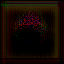

epoche: 20
original


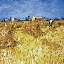

reconstructed


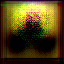

epoche: 30
original


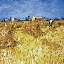

reconstructed


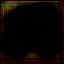

epoche: 40
original


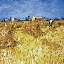

reconstructed


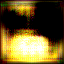

epoche: 50
original


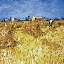

reconstructed


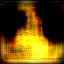

epoche: 60
original


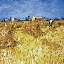

reconstructed


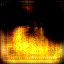

epoche: 70
original


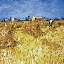

reconstructed


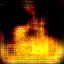

epoche: 80
original


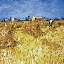

reconstructed


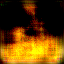

epoche: 90
original


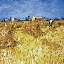

reconstructed


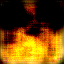

epoche: 100
original


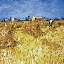

reconstructed


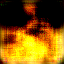

epoche: 110
original


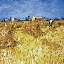

reconstructed


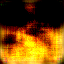

epoche: 120
original


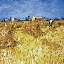

reconstructed


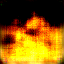

epoche: 130
original


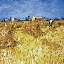

reconstructed


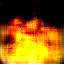

epoche: 140
original


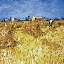

reconstructed


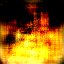

epoche: 150
original


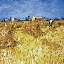

reconstructed


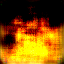

epoche: 160
original


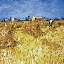

reconstructed


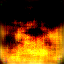

epoche: 170
original


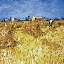

reconstructed


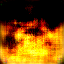

epoche: 180
original


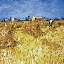

reconstructed


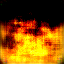

epoche: 190
original


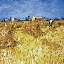

reconstructed


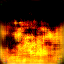

epoche: 200
original


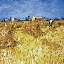

reconstructed


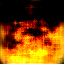

epoche: 210
original


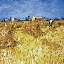

reconstructed


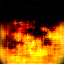

epoche: 220
original


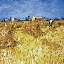

reconstructed


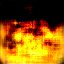

epoche: 230
original


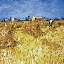

reconstructed


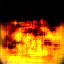

epoche: 240
original


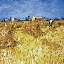

reconstructed


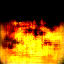

epoche: 250
original


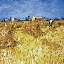

reconstructed


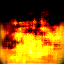

epoche: 260
original


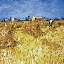

reconstructed


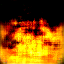

epoche: 270
original


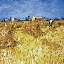

reconstructed


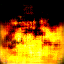

epoche: 280
original


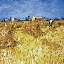

reconstructed


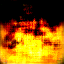

epoche: 290
original


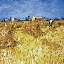

reconstructed


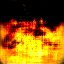

epoche: 300
original


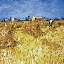

reconstructed


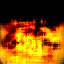

epoche: 310
original


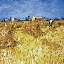

reconstructed


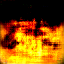

epoche: 320
original


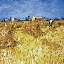

reconstructed


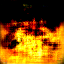

epoche: 330
original


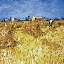

reconstructed


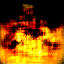

epoche: 340
original


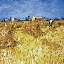

reconstructed


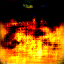

epoche: 350
original


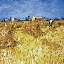

reconstructed


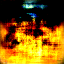

epoche: 360
original


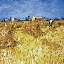

reconstructed


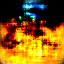

epoche: 370
original


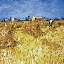

reconstructed


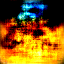

epoche: 380
original


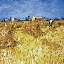

reconstructed


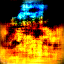

epoche: 390
original


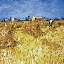

reconstructed


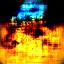

epoche: 400
original


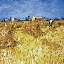

reconstructed


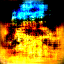

epoche: 410
original


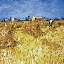

reconstructed


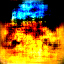

epoche: 420
original


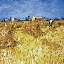

reconstructed


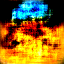

epoche: 430
original


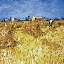

reconstructed


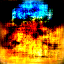

epoche: 440
original


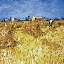

reconstructed


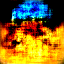

epoche: 450
original


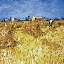

reconstructed


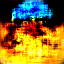

epoche: 460
original


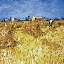

reconstructed


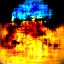

epoche: 470
original


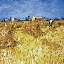

reconstructed


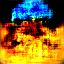

epoche: 480
original


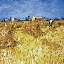

reconstructed


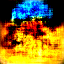

epoche: 490
original


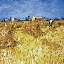

reconstructed


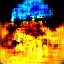

epoche: 500
original


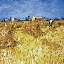

reconstructed


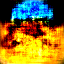

epoche: 510
original


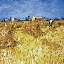

reconstructed


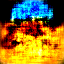

epoche: 520
original


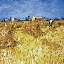

reconstructed


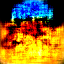

epoche: 530
original


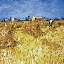

reconstructed


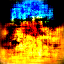

epoche: 540
original


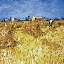

reconstructed


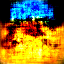

epoche: 550
original


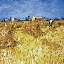

reconstructed


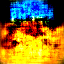

epoche: 560
original


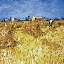

reconstructed


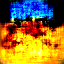

epoche: 570
original


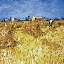

reconstructed


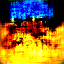

epoche: 580
original


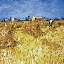

reconstructed


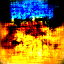

epoche: 590
original


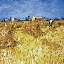

reconstructed


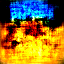

epoche: 600
original


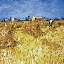

reconstructed


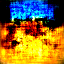

epoche: 610
original


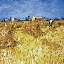

reconstructed


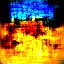

epoche: 620
original


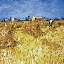

reconstructed


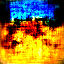

epoche: 630
original


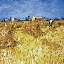

reconstructed


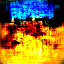

epoche: 640
original


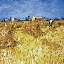

reconstructed


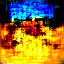

epoche: 650
original


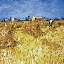

reconstructed


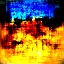

epoche: 660
original


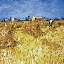

reconstructed


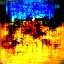

epoche: 670
original


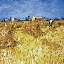

reconstructed


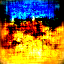

epoche: 680
original


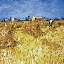

reconstructed


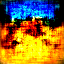

epoche: 690
original


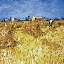

reconstructed


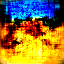

epoche: 700
original


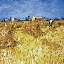

reconstructed


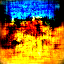

epoche: 710
original


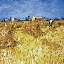

reconstructed


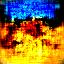

epoche: 720
original


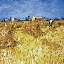

reconstructed


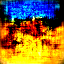

epoche: 730
original


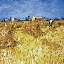

reconstructed


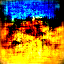

epoche: 740
original


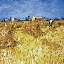

reconstructed


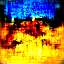

epoche: 750
original


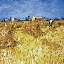

reconstructed


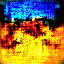

epoche: 760
original


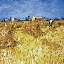

reconstructed


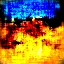

epoche: 770
original


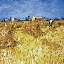

reconstructed


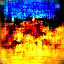

epoche: 780
original


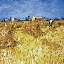

reconstructed


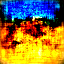

epoche: 790
original


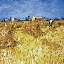

reconstructed


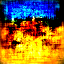

epoche: 800
original


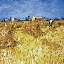

reconstructed


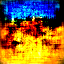

epoche: 810
original


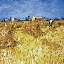

reconstructed


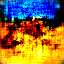

epoche: 820
original


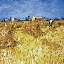

reconstructed


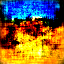

epoche: 830
original


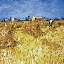

reconstructed


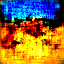

epoche: 840
original


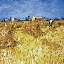

reconstructed


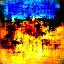

epoche: 850
original


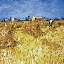

reconstructed


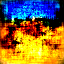

epoche: 860
original


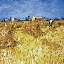

reconstructed


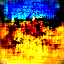

epoche: 870
original


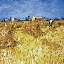

reconstructed


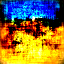

epoche: 880
original


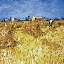

reconstructed


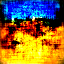

epoche: 890
original


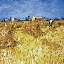

reconstructed


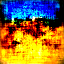

epoche: 900
original


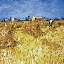

reconstructed


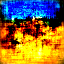

epoche: 910
original


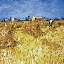

reconstructed


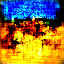

epoche: 920
original


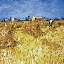

reconstructed


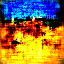

epoche: 930
original


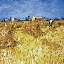

reconstructed


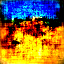

epoche: 940
original


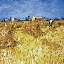

reconstructed


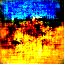

epoche: 950
original


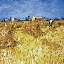

reconstructed


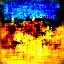

epoche: 960
original


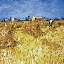

reconstructed


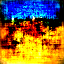

epoche: 970
original


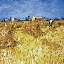

reconstructed


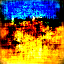

epoche: 980
original


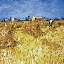

reconstructed


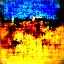

epoche: 990
original


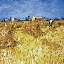

reconstructed


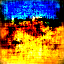

epoche: 1000
original


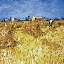

reconstructed


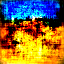

epoche: 1010
original


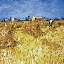

reconstructed


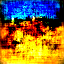

epoche: 1020
original


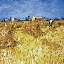

reconstructed


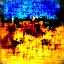

epoche: 1030
original


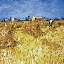

reconstructed


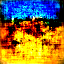

epoche: 1040
original


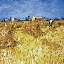

reconstructed


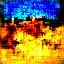

epoche: 1050
original


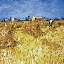

reconstructed


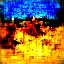

epoche: 1060
original


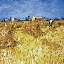

reconstructed


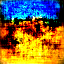

epoche: 1070
original


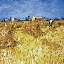

reconstructed


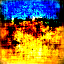

epoche: 1080
original


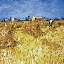

reconstructed


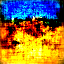

epoche: 1090
original


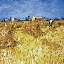

reconstructed


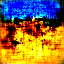

epoche: 1100
original


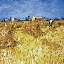

reconstructed


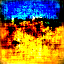

epoche: 1110
original


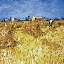

reconstructed


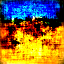

epoche: 1120
original


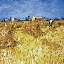

reconstructed


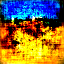

epoche: 1130
original


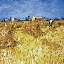

reconstructed


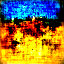

epoche: 1140
original


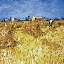

reconstructed


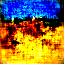

epoche: 1150
original


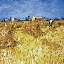

reconstructed


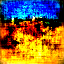

epoche: 1160
original


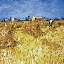

reconstructed


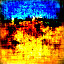

epoche: 1170
original


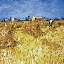

reconstructed


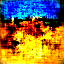

epoche: 1180
original


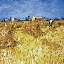

reconstructed


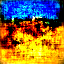

epoche: 1190
original


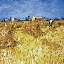

reconstructed


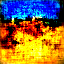

epoche: 1200
original


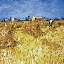

reconstructed


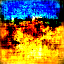

epoche: 1210
original


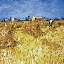

reconstructed


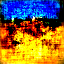

epoche: 1220
original


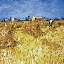

reconstructed


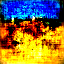

epoche: 1230
original


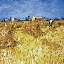

reconstructed


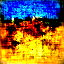

epoche: 1240
original


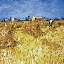

reconstructed


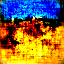

epoche: 1250
original


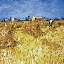

reconstructed


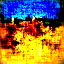

epoche: 1260
original


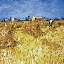

reconstructed


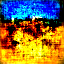

epoche: 1270
original


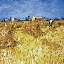

reconstructed


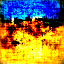

epoche: 1280
original


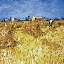

reconstructed


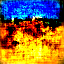

epoche: 1290
original


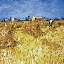

reconstructed


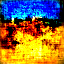

epoche: 1300
original


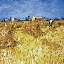

reconstructed


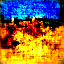

epoche: 1310
original


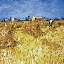

reconstructed


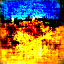

epoche: 1320
original


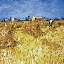

reconstructed


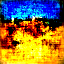

epoche: 1330
original


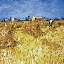

reconstructed


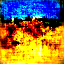

epoche: 1340
original


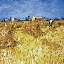

reconstructed


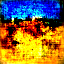

epoche: 1350
original


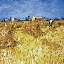

reconstructed


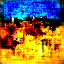

epoche: 1360
original


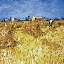

reconstructed


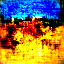

epoche: 1370
original


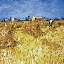

reconstructed


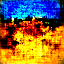

epoche: 1380
original


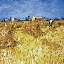

reconstructed


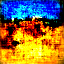

epoche: 1390
original


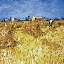

reconstructed


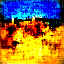

epoche: 1400
original


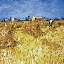

reconstructed


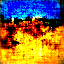

epoche: 1410
original


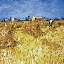

reconstructed


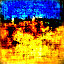

epoche: 1420
original


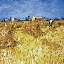

reconstructed


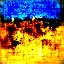

epoche: 1430
original


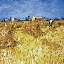

reconstructed


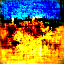

epoche: 1440
original


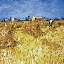

reconstructed


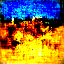

epoche: 1450
original


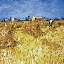

reconstructed


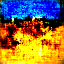

epoche: 1460
original


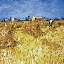

reconstructed


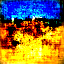

epoche: 1470
original


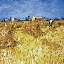

reconstructed


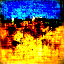

epoche: 1480
original


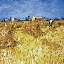

reconstructed


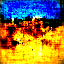

epoche: 1490
original


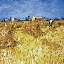

reconstructed


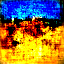

epoche: 1500
original


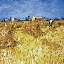

reconstructed


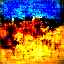

epoche: 1510
original


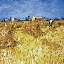

reconstructed


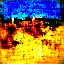

epoche: 1520
original


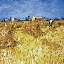

reconstructed


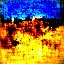

epoche: 1530
original


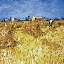

reconstructed


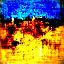

epoche: 1540
original


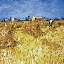

reconstructed


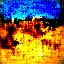

epoche: 1550
original


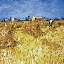

reconstructed


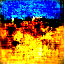

epoche: 1560
original


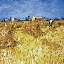

reconstructed


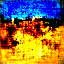

epoche: 1570
original


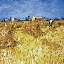

reconstructed


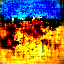

epoche: 1580
original


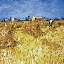

reconstructed


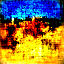

epoche: 1590
original


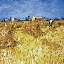

reconstructed


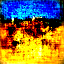

In [34]:
for epoche, tup_list in vanGogh.reconstruction.items():
    
    if not epoche % 10 == 0:
        continue
    print('epoche:', epoche)
    #random.shuffle(tup_list)
    for original, reconstructed in tup_list:

        orig_ = original[0].cpu().permute(1,2,0).detach().numpy()*255
        recons_ = reconstructed[0].cpu().permute(1,2,0).detach().numpy()*255
        print('original')
        cv2_imshow(orig_)
        print('reconstructed')
        cv2_imshow(recons_)
        break

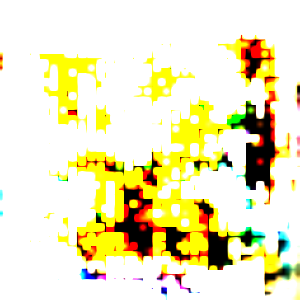

In [31]:
vanGogh.model.eval()
tensor = torch.randn_like(torch.zeros(30)).to(device)
tensor = torch.tensor([random.randint(-100,10) for _ in range(30)]).float().to(device)
#tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
vanGogh.model.batch_size = 1
img = vanGogh.model.decode_convolutions(tensor).cpu()
if vanGogh.color:
    img = img.permute(0,2,3,1).detach().numpy()[0]*255
else:
    img = img.detach().numpy()[0][0]*255
#print(img.shape)
img = cv2.resize(img, (300,300))
cv2_imshow(img)

(3, 64, 64)


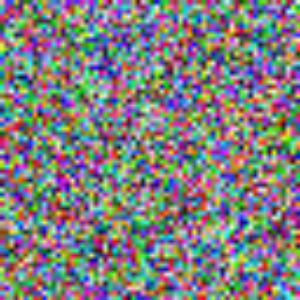

In [33]:
vanGogh.model.eval()
tensor = torch.randn_like(torch.zeros(30)).to(device)
image_ = list()
for _ in range(3):
    random_image = list()
    for _ in range(64):
        random_image.append([random.random() for k in range(64)])
    image_.append(random_image)
random_image = np.array(image_)
print(random_image.shape)
tensor = torch.from_numpy(random_image).to(device)
#tensor = torch.tensor([random.random() for _ in range(30)]).float().to(device)
#tensor = torch.randn_like(torch.zeros(emb_size)).to(device)
#vanGogh.model.batch_size = 1
#img = vanGogh.model.decode_convolutions(tensor).cpu()
#if vanGogh.color:
img = tensor.permute(1,2,0).cpu().detach().numpy()*255
#else:
#    img = img.detach().numpy()[0][0]*255
#print(img.shape)
img = cv2.resize(img, (300,300))
cv2_imshow(img)

# Anhang

In [ ]:
path = '/content/drive/My Drive/ImageGeneration/artists'
artists = [f for f in os.listdir(path) if not os.path.isfile(f)]
print(artists)

images_list = list()
for i, image in tqdm(enumerate(images)):
    img_path = os.path.join(path, image)
    #img = mpimg.imread(img_path)

    #bilder grau einlesen
    img = cv2.imread(img_path, 1)
    #bilder auf einheitliche größe bringen
    img = cv2.resize(img, (400,400))
    #bilder abzeigen (enabled)
    #cv2_imshow(img)
    #img_grey = rgb2gray(img)
    images_list.append(img)
    #plt.imshow(img)
    #if i == 5:
    #    break
len(images_list)

['Vincent_van_Gogh', 'Andy_Warhol', 'Pieter_Bruegel']


NameError: ignored

In [ ]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD